Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 160, 320, 3)   0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cropping2d_1 (Cropping2D)        (None, 90, 320, 3)    0           lambda_1[0][0]                   
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 43, 158, 24)   1824        cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 20, 77, 36)    21636       convolution2d_1[0][0]            
___________________________________________________________________________________________

C:\Users\paul-otniel.barna\AppData\Local\Continuum\miniconda3\envs\paulbarna\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 0.02034, saving model to model.h5
33856/33808 [==============================] - 893s - loss: 0.0249 - val_loss: 0.0203
Epoch 2/8
33824/33808 [==============================] - 893s - loss: 0.0199 - val_loss: 0.0172
Epoch 3/8
33856/33808 [==============================] - 917s - loss: 0.0180 - val_loss: 0.0172
Epoch 4/8
33824/33808 [==============================] - 909s - loss: 0.0176 - val_loss: 0.0176
Epoch 5/8
33856/33808 [==============================] - 900s - loss: 0.0162 - val_loss: 0.0177
Epoch 6/8
33824/33808 [==============================] - 887s - loss: 0.0163 - val_loss: 0.0151
Epoch 7/8
33856/33808 [==============================] - 907s - loss: 0.0154 - val_loss: 0.0149
Epoch 8/8
33824/33808 [==============================] - 898s - loss: 0.0151 - val_loss: 0.0142
dict_keys(['loss', 'val_loss'])
Loss
[0.024866683375167824, 0.019898606340912794, 0.018049063481432728, 0.017613978370981838, 0.016156118274235038, 0.016319308314532

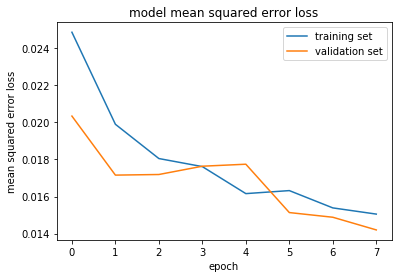

In [1]:
	# Imports
	import json
	import os
	import csv
	import sklearn
	import cv2

	import matplotlib.pyplot as plt
	import numpy as np
	import pandas as pd
	from keras.applications.vgg16 import VGG16
	from keras.callbacks import EarlyStopping, ModelCheckpoint
	from keras.layers import Convolution2D, Input, Dropout, Cropping2D
	from keras.layers import Flatten, Dense, Lambda
	from keras.models import Sequential,Model
	from keras.utils.visualize_util import plot
	from keras.preprocessing.image import ImageDataGenerator
	from sklearn.model_selection import train_test_split
	from keras.utils import np_utils
	from keras.utils.np_utils import to_categorical
	from itertools import chain
	from keras.preprocessing.image import *
	from keras.preprocessing import image
	from keras.layers.pooling import MaxPooling2D

	np.random.seed(7)

	# Data loading
	def ReadCsv(Path):
		"""
		Returns the rows content from the driving log csv files.
		"""
		lines = []
		AWSLinesTotal=[]
		with open(Path + '/driving_log.csv') as f:
			reader = csv.reader(f)
			for row in reader:
				lines.append(row)

		for line in lines:
			AWSLines=[]
			source_path=line[0]
			filename=source_path.split('/')[-1]
			current_path=Path+'/IMG/'+filename
			AWSLines.append(current_path)
			source_path=line[1]
			filename=source_path.split('/')[-1]
			current_path=Path+'/IMG/'+filename
			AWSLines.append(current_path)
			source_path=line[2]
			filename=source_path.split('/')[-1]
			current_path=Path+'/IMG/'+filename
			AWSLines.append(current_path)
			AWSLines.append(line[3])
			AWSLines.append(line[4])
			AWSLines.append(line[5])
			AWSLinesTotal.append(AWSLines)
			
		return AWSLinesTotal
			

	def generator(samples, batch_size=32):
		num_samples = len(samples)
		while 1: # Loop forever so the generator never terminates
			samples = sklearn.utils.shuffle(samples)
			for offset in range(0, num_samples, batch_size):
				batch_samples = samples[offset:offset+batch_size]

				images = []
				angles = []
				for batch_sample,steering_sample in batch_samples:
					#read image and convert it to RGB value
					rawImage = cv2.imread(batch_sample)
					RGBimage = cv2.cvtColor(rawImage, cv2.COLOR_BGR2RGB)
					# append image and a flipped image
					images.append(RGBimage)
					images.append(cv2.flip(RGBimage,1)) 
					# append the steering command and an additional inverted measurement for the flipped image
					angles.append(steering_sample)
					angles.append(-1.0*steering_sample)

				X_train = np.array(images)
				y_train = np.array(angles)
				yield sklearn.utils.shuffle(X_train, y_train)
				

	def DataSetsGenerator():
		"""
		"""
		# get the folders path for each of the instances:
		# Car running on the center of the road (track 1 and track 2)
		# Car running on the center of the road counter-clockwise (track 1)
		# Recover maneuvers (track 1)
		# Recover maneuvers if the car veers off to the side (track 1)
		
		Folders = [i[0] for i in os.walk(r'''C:/Oti/UDACITY/CarND-Behavioral-Cloning/data''')]	

		DataSets = list(filter(lambda directory: os.path.isfile(directory + '/driving_log.csv'), Folders))
		
		correction = 0.2
		img_center_List=[]
		img_left_List=[]
		img_right_List=[]
		steering_center_List=[]
		steering_left_List=[]
		steering_right_List=[]

		for Folder in DataSets:
			CsvRow=ReadCsv(Folder)
			steering_center=[]
			steering_left=[]
			steering_right=[]
			img_center=[]
			img_left=[]
			img_right=[]
			for row in CsvRow:
				steering_center.append(float(row[3]))
				# create adjusted steering measurements for the side camera images
				steering_left.append(float(row[3]) + correction)
				steering_right.append(float(row[3]) - correction)
				# Append images
				img_center.append(row[0].strip())
				img_left.append(row[1].strip())
				img_right.append(row[2].strip())
			# add images and steering commands to the data set
			img_center_List.extend(img_center)
			img_left_List.extend(img_left)
			img_right_List.extend(img_right)
			steering_center_List.extend(steering_center)
			steering_left_List.extend(steering_left)
			steering_right_List.extend(steering_right)
			
			
		car_images=[]
		steering_angles=[]
			
		car_images.extend(img_center_List)
		car_images.extend(img_left_List)
		car_images.extend(img_right_List)

		steering_angles.extend(steering_center_List)
		steering_angles.extend(steering_left_List)
		steering_angles.extend(steering_right_List)
		
		# split the data into training samples (80%) and validation samples (20%)
		samples = list(zip(car_images, steering_angles))

		training_samples, validation_samples = train_test_split(samples, test_size=0.2)
		
		# call the generator function (similar one to the lecture example)
		training_generator = generator(training_samples, batch_size=32)
		validation_generator = generator(validation_samples, batch_size=32)


		return (training_generator,validation_generator,len(training_samples),len(validation_samples))

	def NVIDIANetwork():
		"""
		NVIDIA network architecture which consists of 9 layers, including a normalization layer, 5 convolutional layers, and 3 fully connected layers
		"""
		model = Sequential()
		# set up lambda layer
		model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
		# set up cropping2D layer
		model.add(Cropping2D(cropping=((50,20), (0,0))))
		model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
		model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
		model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
		model.add(Convolution2D(64,3,3, activation='relu'))
		model.add(Convolution2D(64,3,3, activation='relu'))
		model.add(Flatten())
		model.add(Dense(100))
		model.add(Dense(50))
		model.add(Dense(10))
		model.add(Dense(1))
		
		return model

	if __name__ == '__main__':

		
		model = NVIDIANetwork()
	   
		model.summary()
        
		plot(model, to_file='model.png', show_shapes=True)

		model.compile(optimizer='adam', loss='mse')

		model_json = model.to_json()
		
		with open('model.json', 'w') as f:
			json.dump(model_json, f)

		training_sets, validation_sets, training_sets_samples, validation_sets_samples = DataSetsGenerator()       
		
		# create a model checkpoint
		Model_Checkpoint = ModelCheckpoint('model.h5', monitor='val_loss', verbose=1, save_best_only=True,
									 save_weights_only=False, mode='auto')
		
		# set an early stopping limit of epochs if there is no improvement
		Early_Stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1, mode='auto')
		
		# generate model history
		Model_History = model.fit_generator(training_sets,
									  samples_per_epoch=training_sets_samples,
									  validation_data=validation_sets,
									  nb_val_samples=validation_sets_samples,
									  nb_epoch=8,
									  callbacks=[Model_Checkpoint, Early_Stopping])
		# model history
		print(Model_History.history.keys())
		print('Loss')
		print(Model_History.history['loss'])
		print('Validation Loss')
		print(Model_History.history['val_loss'])
		
		#### plot the training and validation loss for each epoch
		plt.plot(Model_History.history['loss'])
		plt.plot(Model_History.history['val_loss'])
		plt.title('model mean squared error loss')
		plt.ylabel('mean squared error loss')
		plt.xlabel('epoch')
		plt.legend(['training set', 'validation set'], loc='upper right')
		plt.show()